# Speech Understanding 
# Lecture 8: Spectrogram

### Mark Hasegawa-Johnson, KCGI

Here are the contents:
1. <a href="#section2">Using librosa to read speech audio files</a>
1. <a href="#section3">Spectrogram = log(abs(fft(enframe(speech))))</a>
1. <a href="#section4">Narrowband and Wideband spectrograms</a>
1. <a href="#homework">Homework</a>

<a id='section2'></a>

## 1. Using [librosa](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html) to read speech audio files

[librosa](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html) is a very general package for synthesizing and analyzing audio files.  For now, let's use it to read in the `.webm` file you just created.  First, you need to install it.  In this line, the `-q` flag prevents pip from printing anything unless there is an error.  If nothing is printed, then you have no errors:

In [41]:
!pip -q install librosa

The [librosa.load](https://librosa.org/doc/latest/generated/librosa.load.html#librosa.load) function gives some useful features:

* It can read from a variety of audio file formats, including m4a
* Suppose `train.m4a` has 44100 samples/second, but you only want 8000 samples/second.  By specifying `sr=8000`, you can tell `librosa.load` to change the sampling rate to 8000 samples/second.

The following block of code loads a waveform, `train.m4a`, that's distributed with this repository.  If you'd prefer to use your own voice, please feel free!

/var/folders/y5/kdcw0kfn2xl71bwrvl50bj1m0000gn/T/ipykernel_26365/1122628400.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, Fs = librosa.load('train.m4a',sr=8000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Text(0.5, 1.0, 'Recording sampled at 8000 samples/second')

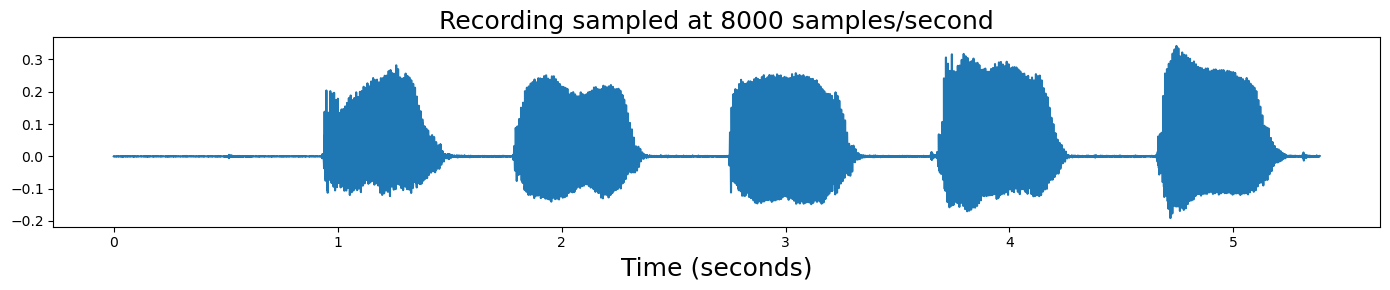

In [42]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

speech, Fs = librosa.load('train.m4a',sr=8000)
speech_time_axis = np.arange(len(speech))/Fs

fig = plt.figure(figsize=(14,3),layout='tight')
subplot = fig.subplots(1,1)
subplot.plot(speech_time_axis,speech)
subplot.set_xlabel('Time (seconds)',fontsize=18)
subplot.set_title('Recording sampled at %d samples/second'%(Fs),fontsize=18)


In [43]:
import IPython.display
IPython.display.Audio(speech,rate=Fs)

<a id='section3'></a>

## 2. Spectrogram = clip(log(abs(fft(enframe(speech)))))

* A Fourier transform finds out which tones are present in a sound
* ... but speech changes over time!

In order to solve this problem, we use the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform">short-time Fourier transform, or STFT</a>.  The STFT has two steps:

1. **enframe:** divide speech into overlapping frames; put each in one column of a matrix
2. **fft:** take the FFT of each row

The <a href="https://en.wikipedia.org/wiki/Loudness">loudness</a> of a sound is roughly proportional to the <a href="https://en.wikipedia.org/wiki/Logarithm">logarithm</a> of its magnitude, so a <a href="https://en.wikipedia.org/wiki/Spectrogram">spectrogram</a> shows log magnitude:

3. **abs:** compute the absolute value
4. **log:** compute the logarithm
5. **clip:** clip values that are too small

### 2.1. Divide speech into overlapping frames

We will use frames that are $N$ samples long, with a step size of $S$ samples between frame starting points.  Thus they overlap by $N-S$ samples.

For now, let's use 25ms frames with a 10ms skip, i.e., $N=0.025F_s$ and $S=0.01F_s$.

In [44]:
N = int(0.025*Fs)
S = int(0.01*Fs)
speech_frames = np.array([ speech[m:m+N] for m in range(0,len(speech)-N,S) ])

print('The speech is %d samples long = (%d frames)*(%d samples between frames) + %d samples'%(len(speech),len(speech_frames),S,N))
print('The shape of the speech_frames matrix is',speech_frames.shape)

The speech is 43085 samples long = (537 frames)*(80 samples between frames) + 200 samples
The shape of the speech_frames matrix is (537, 200)


We can plot this as an image.  Most of the samples will be near zero, and only a few will be strongly negative or strongly positive.

Each row is a frame.  To put the frame index on the X-axis and sample on the Y-axis, we can use <a href="https://numpy.org/doc/stable/reference/generated/numpy.ndarray.transpose.html">np.ndarray.transpose</a>:

Text(0.5, 1.0, 'Frames of /a,i,u,e,o/, 25ms frames with a 10ms step')

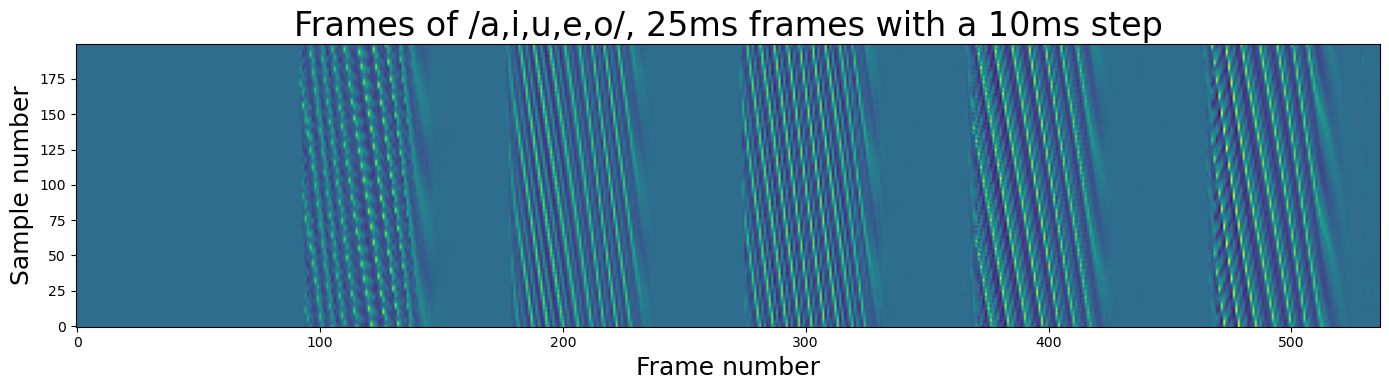

In [50]:
fig = plt.figure(figsize=(14,4),layout='tight')
subplot = fig.subplots(1,1)
subplot.imshow(speech_frames.transpose(),aspect='auto',origin='lower')
subplot.set_xlabel('Frame number',fontsize=18)
subplot.set_ylabel('Sample number',fontsize=18)
subplot.set_title('Frames of /a,i,u,e,o/, 25ms frames with a 10ms step',fontsize=24)

### 2.2 Take the Magnitude FFT of each frame to get the MSTFT

The MSTFT is computed by taking the FFT of each row (the row is `axis=1`), then taking the magnitude (absolute value) of the result:

Text(0.5, 1.0, 'MSTFT of /a,i,u,e,o/, 25ms frames with a 10ms step')

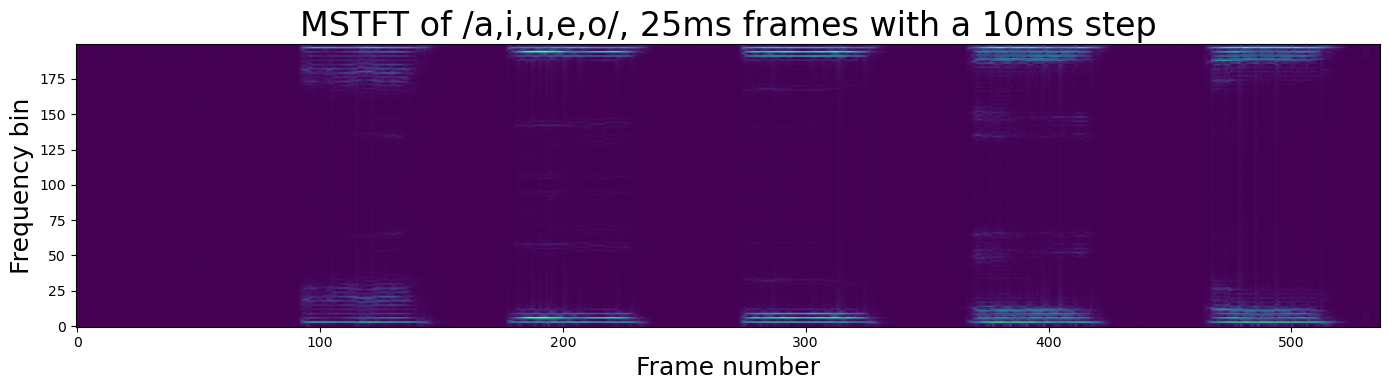

In [51]:
mstft = np.abs(np.fft.fft(speech_frames, axis=1))

fig = plt.figure(figsize=(14,4),layout='tight')
subplot = fig.subplots(1,1)
subplot.imshow(mstft.transpose(),aspect='auto',origin='lower')
subplot.set_xlabel('Frame number',fontsize=18)
subplot.set_ylabel('Frequency bin',fontsize=18)
subplot.set_title('MSTFT of /a,i,u,e,o/, 25ms frames with a 10ms step',fontsize=24)


Let's make three modifications:

1. The high frequencies in the FFT are just an aliased copy of the low frequencies.  Let's get rid of them by choosing `mstft[:,0:100]`.
2. Let's label the frequency axis in **Hertz** ($f$) instead of **frequency bins** ($k$).  Remember the frequency scaling formula from last time:

$$f = \left(\frac{F_s}{N}\right)k$$

3. Similarly, let's label the X-axis in **seconds** ($t$) instead of **frames** ($m$).  Since each frame starts $S$ samples after the last one, the conversion is

$$t = \left(\frac{S}{F_s}\right) m$$

Text(0.5, 1.0, 'MSTFT of /a,i,u,e,o/, 25ms frames with a 10ms step')

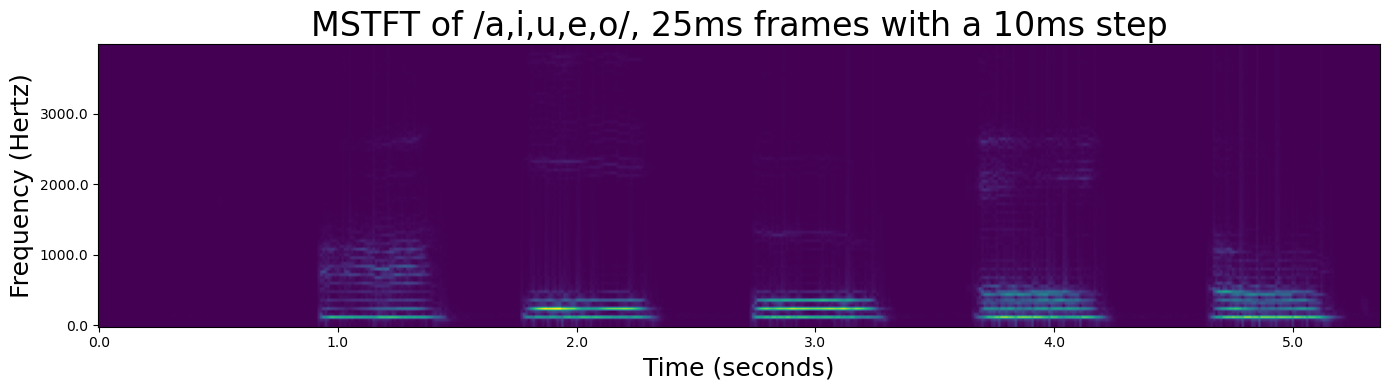

In [52]:
N = int(0.025*Fs)
S = int(0.01*Fs)

fig = plt.figure(figsize=(14,4),layout='tight')
subplot = fig.subplots(1,1)
subplot.imshow(mstft[:,0:100].transpose(),aspect='auto',origin='lower')

k = np.arange(0,100,25)
f = (Fs/N)*k
m = np.arange(0,537,100)
t = (S/Fs)*m
subplot.set_xticks(m, t)
subplot.set_yticks(k, f)
subplot.set_xlabel('Time (seconds)',fontsize=18)
subplot.set_ylabel('Frequency (Hertz)',fontsize=18)
subplot.set_title('MSTFT of /a,i,u,e,o/, 25ms frames with a 10ms step',fontsize=24)


### 2.3 Sound Pressure Level (decibels) = 20 * log(MSTFT)

As you can see from the plot above, the MSTFT is close to zero in most frequency bins.  This is because the human ear is more sensitive to low-amplitude signals than the eye!  

* The brightest pixel your eye can see is only about 250 times as bright as the dimmest pixel.
* The loudest sound your ear can hear is 1,000,000 times as loud as the quietest sound.

In order to make the quiet sounds visible to your eye, we can use a logarithm.  The logarithm emphasizes weak sounds, and de-emphasizes loud sounds.

#### Standardization: Use decibels, `20*log10(mstft)`
If you use `np.log` to calculate the logarithm, then your spectrogram units are not obvious.  If you use `20*np.log10`, then you can say that your spectrogram expresses levels in units of decibels.  The <a href="https://en.wikipedia.org/wiki/Decibel">decibel</a> is an international standard way of expressing logarithms.  Since it's an international standard, it's nice to use it.

#### Normalization: Clip to 0.001 times the maximum
In order to avoid taking the logarithm of zero, it's a good idea to use `np.amax` to find the max value of the MSTFT, then use `np.maximum` to make sure that the smallest value is 0.001 times the max value.

Text(0.5, 1.0, 'Spectrogram of /a,i,u,e,o/, 25ms frames with a 10ms step')

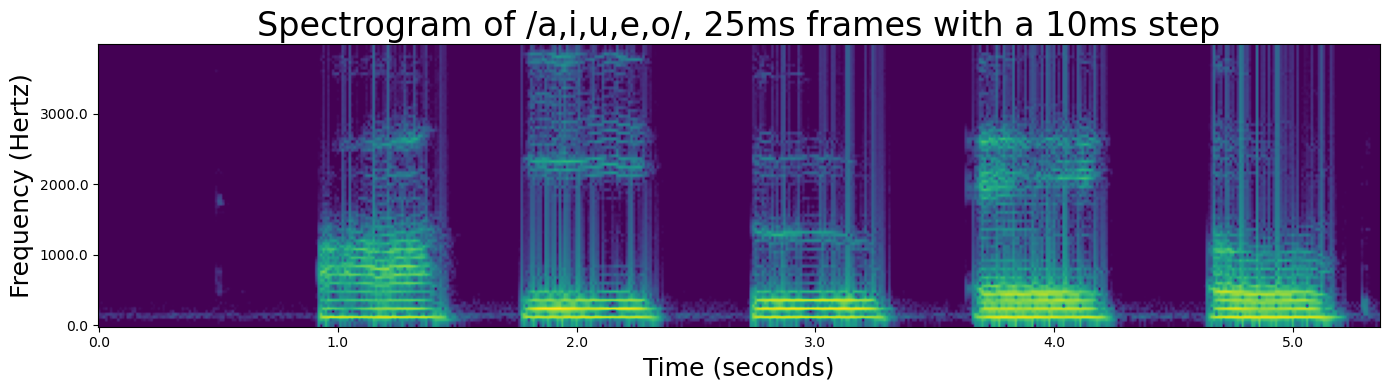

In [53]:
N = int(0.025*Fs)
S = int(0.01*Fs)

sgram = 20*np.log10(np.maximum(0.001*np.amax(mstft),mstft))
                            
fig = plt.figure(figsize=(14,4),layout='tight')
subplot = fig.subplots(1,1)
subplot.imshow(sgram[:,0:100].transpose(),aspect='auto',origin='lower')

subplot.set_xticks(m, t)
subplot.set_yticks(k, f)
subplot.set_xlabel('Time (seconds)',fontsize=18)
subplot.set_ylabel('Frequency (Hertz)',fontsize=18)
subplot.set_title('Spectrogram of /a,i,u,e,o/, 25ms frames with a 10ms step',fontsize=24)


<a id='section4'></a>

## 3. Wideband Spectrograms and Pre-emphasis

#### Pitch = Information about the speaker

The most obvious feature of the spectrogram is the set of horizontal lines.  There are $\approx 8$ horizontal lines per $1000$ Hertz, i.e., $125$ Hertz/line.  These are called the **harmonics** of the **pitch**.  In this case, my pitch frequency is about 125 Hertz.  Notice that my pitch frequency is the same for all five vowels!

#### Spectral Envelope = Information about the vowel

All five vowels have lots of energy at 125Hz.  The other strong frequencies depend on the vowel:

* /a/: high energy at about $(900,1100,2500)$Hz
* /i/: high energy at about $(250,2000,2500)$Hz
* /u/: high energy at about $(250,1100,2300)$Hz
* /e/: high energy at about $(500,2000,2500)$Hz
* /o/: high energy at about $(500,1000)$Hz

... but this information is kind of hard to see, because of the pitch harmonics!

#### Wideband Spectrogram = Hide the pitch by using very short windows

* **narrowband spectrogram=long window:** If the window is longer than one pitch period ($> 1/125\mbox{Hz} = 0.008$ seconds), then the spectrogram is called a **narrowband** spectrogram, and it shows the pitch harmonics.
* **wideband spectrogram=short window:** If the window is less than one pitch period ($<0.008$ seconds), then the spectrogram is called **wideband** spectrogram because it smooths out the pitch harmonics.

Let's create a wideband spectrogram:


Text(0.5, 1.0, 'Wideband Spectrogram of /a,i,u,e,o/, 4ms with a 2ms step')

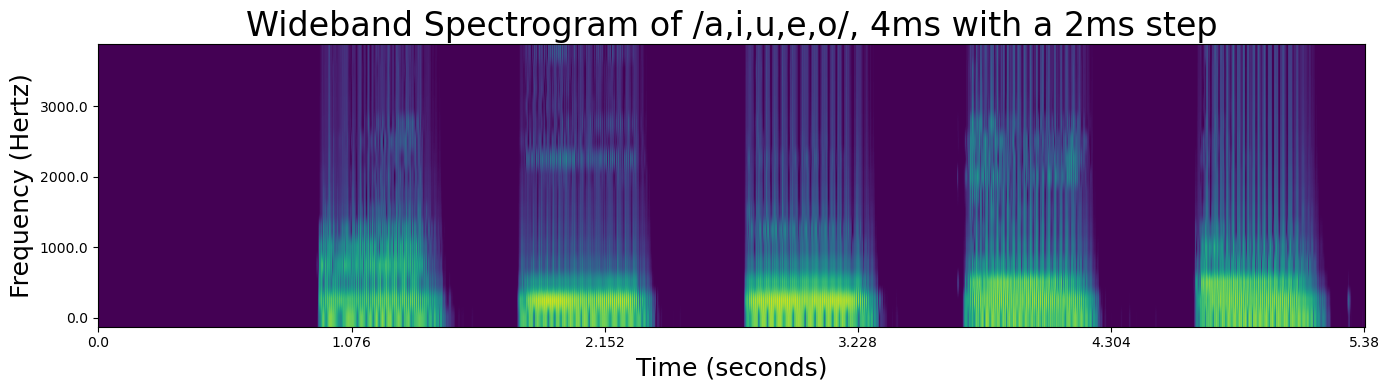

In [61]:
N = int(0.004*Fs)
S = int(0.002*Fs)
frames = np.array([ speech[m:m+N] for m in range(0,len(speech)-N,S) ])
mstft = np.abs(np.fft.fft(frames, axis=1))
sgram = 20*np.log10(np.maximum(0.01*np.amax(mstft),mstft))

fig = plt.figure(figsize=(14,4),layout='tight')
subplot = fig.subplots(1,1)
subplot.imshow(sgram[:,0:int(N/2)].transpose(),aspect='auto',origin='lower')

m = np.arange(0,len(frames),int(len(frames)/5))
t = (S/Fs)*m
k = np.arange(0, int(N/2), int(N/8))
f = (Fs/N)*k

subplot.set_xticks(m, t)
subplot.set_yticks(k, f)
subplot.set_xlabel('Time (seconds)',fontsize=18)
subplot.set_ylabel('Frequency (Hertz)',fontsize=18)
subplot.set_title('Wideband Spectrogram of /a,i,u,e,o/, 4ms with a 2ms step',fontsize=24)


Notice that, even though the pitch harmonics aren't visible any more, it still seems like most of the energy is at 125 Hz.  We can de-emphasize the low-frequency energy using **pre-emphasis**

### Pre-emphasis = analyze $x[n+1]-x[n]$ instead of $x[n]$

Pre-emphasis just means that we analyze `speech[m+1]-speech[m]` instead of `speech[m]`.  By subtracting neighboring samples, we get rid of the low-frequency energy, while keeping the high-frequency energy.

Text(0.5, 1.0, 'Pre-emphasized Wideband Spectrogram of /a,i,u,e,o/')

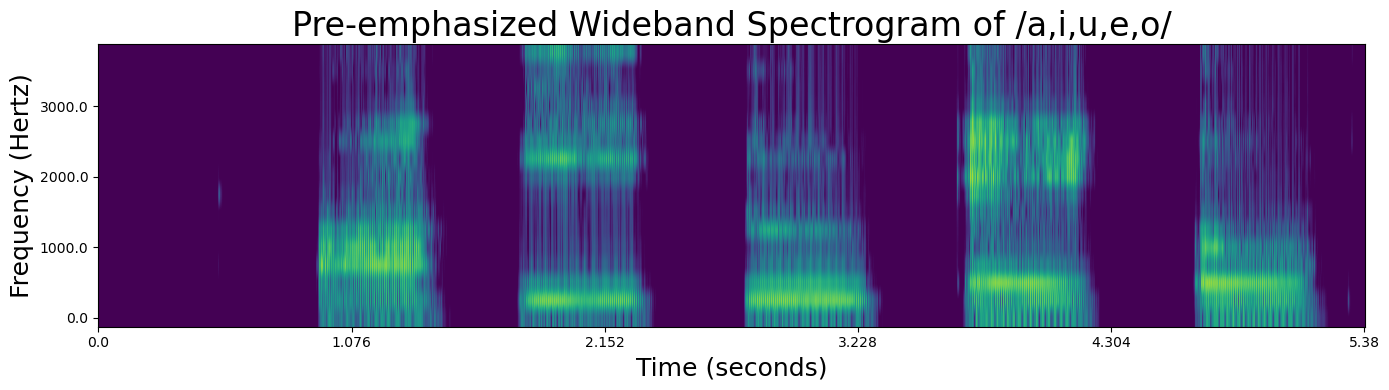

In [62]:
N = int(0.004*Fs)
S = int(0.002*Fs)
frames = np.array([ speech[m+1:m+1+N]-speech[m:m+N] for m in range(0,len(speech)-N,S) ])
mstft = np.abs(np.fft.fft(frames, axis=1))
sgram = 20*np.log10(np.maximum(0.01*np.amax(mstft),mstft))

fig = plt.figure(figsize=(14,4),layout='tight')
subplot = fig.subplots(1,1)
subplot.imshow(sgram[:,0:int(N/2)].transpose(),aspect='auto',origin='lower')

m = np.arange(0,len(frames),int(len(frames)/5))
t = (S/Fs)*m
k = np.arange(0, int(N/2), int(N/8))
f = (Fs/N)*k

subplot.set_xticks(m, t)
subplot.set_yticks(k, f)
subplot.set_xlabel('Time (seconds)',fontsize=18)
subplot.set_ylabel('Frequency (Hertz)',fontsize=18)
subplot.set_title('Pre-emphasized Wideband Spectrogram of /a,i,u,e,o/',fontsize=24)

<a id="homework"></a>

## Homework 

Homework will be graded on Github.com.  Edit the file in this directory called `homework8.py`.  

### Homework 8.1: waveform_to_frames

In [63]:
import importlib, homework8
importlib.reload(homework8)
help(homework8.waveform_to_frames)

Help on function waveform_to_frames in module homework8:

waveform_to_frames(waveform, frame_length, step)
    Chop a waveform into overlapping frames.

    @params:
    waveform (np.ndarray(N)) - the waveform
    frame_length (scalar) - length of the frame, in samples
    step (scalar) - step size, in samples

    @returns:
    frames (np.ndarray((num_frames, frame_length))) - waveform chopped into frames
       frames[m/step,n] = waveform[m+n] only for m = integer multiple of step



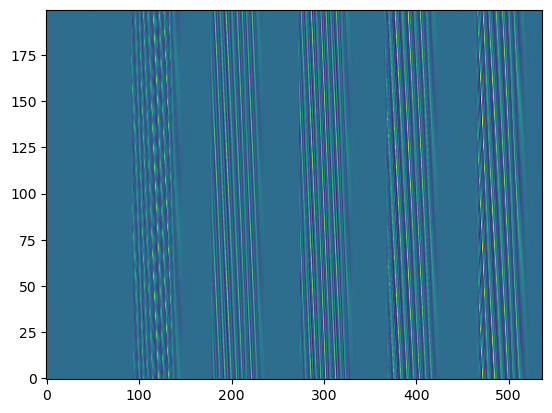

In [67]:
importlib.reload(homework8)
frames = homework8.waveform_to_frames(speech, int(0.025*Fs), int(0.01*Fs))
plt.imshow(frames.transpose(),origin='lower',aspect='auto')

### Homework 8.2: frames_to_mstft

In [73]:
importlib.reload(homework8)
help(homework8.frames_to_mstft)

Help on function frames_to_mstft in module homework8:

frames_to_mstft(frames)
    Take the magnitude FFT of every row of the frames matrix.

    @params:
    frames (np.ndarray((num_frames, frame_length))) - the speech samples

    @returns:
    mstft (np.ndarray((num_frames, frame_length))) - the magnitude short-time Fourier transform



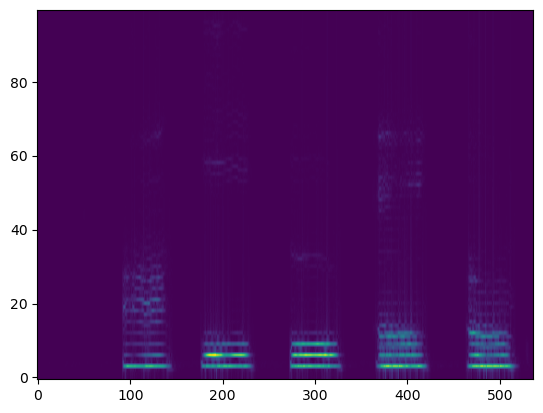

In [75]:
importlib.reload(homework8)
mstft = homework8.frames_to_mstft(frames)
plt.imshow(mstft[:,0:100].transpose(),origin='lower',aspect='auto')

### Homework 8.3: mstft_to_spectrogram

In [77]:
importlib.reload(homework8)
help(homework8.mstft_to_spectrogram)

Help on function mstft_to_spectrogram in module homework8:

mstft_to_spectrogram(mstft)
    Convert max(0.001*amax(mstft), mstft) to decibels.

    @params:
    stft (np.ndarray((num_frames, frame_length))) - magnitude short-time Fourier transform

    @returns:
    spectrogram (np.ndarray((num_frames, frame_length)) - spectrogram

    The spectrogram should be expressed in decibels (20*log10(mstft)).
    np.amin(spectrogram) should be no smaller than np.amax(spectrogram)-60



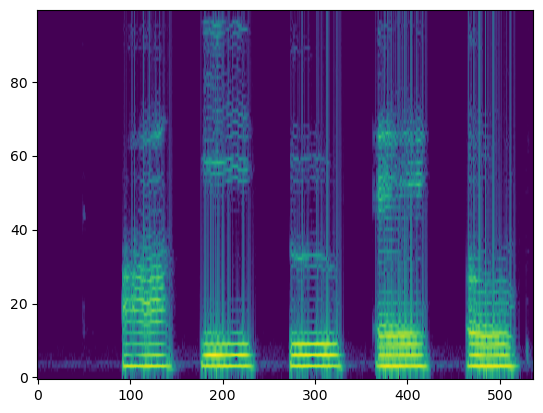

In [79]:
importlib.reload(homework8)
spectrogram = homework8.mstft_to_spectrogram(mstft)
plt.imshow(spectrogram[:,0:100].transpose(),origin='lower',aspect='auto')

### Receiving your grade

In order to receive a grade for your homework, you need to:

1. Run the following code block on your machine.  The result may list some errors, and then in the very last line, it will show a score.  That score (between 0% and 100%) is the grade you have earned so far.  If you want to earn a higher grade, please continue editing `homework3.py`, and then run this code block again.
1. When you are happy with your score (e.g., when it reaches 100%), choose `File` $\Rightarrow$ `Save and Checkpoint`.  Then use `GitHub Desktop` to commit and push your changes.
1. Make sure that the 100% shows on your github repo on github.com.  If it doesn't, you will not receive credit.

In [81]:
import importlib, grade
importlib.reload(grade)

/Users/jhasegaw/Dropbox/mark/teaching/kcgi/intro_speech_understanding/lec08/grade.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, Fs = sf.read('train.wav')
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'train.wav'